# Descriptive statistics - Leaf Area Index (LAI) Maps

**Objective:** This notebook provides descriptive statistics of leaf area index (LAI) maps to understand the distribution and characteristics of LAI values. 

**Data:** LAI maps were generated using PROSAIL, a radiative transfer model that was applied on multispectral imagery from uncrewed aerial systems (UAS) and satellite (S2). 

**Methods:** This notebook will explore the following aspects of the LAI maps:

* Distribution of LAI values
* Summary statistics (e.g., mean, median, standard deviation)

**Notebook Structure:** This notebook is organized into the following sections:

1. Data Import and Preparation
2. Descriptive Statistics

### 1. Set up environment

In [142]:
import os
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
from rasterio.crs import CRS
import rioxarray as rxr
import rasterio as rio
import xarray
#from rasterio.plot import show
import pandas as pd
#from datetime import timedelta
import datetime as dt
import matplotlib.gridspec as gridspec
from shapely.geometry import Point
import matplotlib.patches as mpatches

In [143]:
os.chdir(r'D:\OneDrive - Institut für Zuckerrübenforschung\03_projects\proj_cercospoRa')
current_date = dt.date.today()
out = r"D:\OneDrive - Institut für Zuckerrübenforschung\03_projects\proj_cercospoRa\04_output\03_data_analysis"

### 2. Import raster and vector data

In [144]:
treated_ino = r"03_proc_data\Inoculation_circle\20250504_treated_ino.gpkg"
untreated_ino = r"03_proc_data\Inoculation_circle\20250504_untreated_ino.gpkg"

treated_roi = r"03_proc_data\Inoculation_circle\20250504_treated_roi_diff.gpkg"
untreated_roi = r"03_proc_data\Inoculation_circle\20250504_untreated_roi_diff.gpkg"

# UAS
lai_uas_1 = r"03_proc_data\LAI_maps\UAV\2022_06_14.tif"
lai_uas_2 = r"03_proc_data\LAI_maps\UAV\2022_06_28.tif"
# Sentinel 2
lai_s2_1 = r"03_proc_data\LAI_maps\S2\2022_06_10.tif"
lai_s2_2 = r"03_proc_data\LAI_maps\S2\2022_06_30.tif"
# Sentinel 2 Superresolution (https://medium.com/@ya_71389/sentinel-2-deep-resolution-3-0-c71a601a2253)
lai_s2s_1 = r"03_proc_data\superesolution\results_superesolution\LAI_maps_superresolution\S2\2022_06_10_superesolution.tif"
lai_s2s_2 = r"03_proc_data\superesolution\results_superesolution\LAI_maps_superresolution\S2\2022_06_30_superesolution.tif"

# Load the polygon layers
treated_ino = gpd.read_file(treated_ino)
untreated_ino = gpd.read_file(untreated_ino)

treated_roi = gpd.read_file(treated_roi)
untreated_roi = gpd.read_file(untreated_roi)

uas_1 = rxr.open_rasterio(lai_uas_1)
uas_2 = rxr.open_rasterio(lai_uas_2)

s2_1 = rxr.open_rasterio(lai_s2_1)
s2_2 = rxr.open_rasterio(lai_s2_1)

s2s_1 = rxr.open_rasterio(lai_s2s_1)
s2s_2 = rxr.open_rasterio(lai_s2s_1)

print(f"⚠️ S2 early lai raster CRS: {s2_1.rio.crs}")
print(f"⚠️ S2 later lai raster CRS: {s2_2.rio.crs}")

print(f"⚠️ S2S early lai raster CRS: {s2s_1.rio.crs}")
print(f"⚠️ S2S later lai raster CRS: {s2s_2.rio.crs}")

print(f"⚠️ UAS early lai raster CRS: {uas_1.rio.crs}")
print(f"⚠️ UAS later lai raster CRS: {uas_2.rio.crs}")

⚠️ S2 early lai raster CRS: EPSG:32632
⚠️ S2 later lai raster CRS: EPSG:32632
⚠️ S2S early lai raster CRS: EPSG:32632
⚠️ S2S later lai raster CRS: EPSG:32632
⚠️ UAS early lai raster CRS: EPSG:4326
⚠️ UAS later lai raster CRS: EPSG:4326


### 3. Reproject CRS

In [145]:
uas_1_rp = uas_1.rio.reproject("EPSG:32632")
uas_2_rp = uas_2.rio.reproject("EPSG:32632")

print(f"⚠️ UAS 1 reprojected raster CRS: {uas_1_rp.rio.crs}")
print(f"⚠️ UAS 2 reprojected raster CRS: {uas_2_rp.rio.crs}")

⚠️ UAS 1 reprojected raster CRS: EPSG:32632
⚠️ UAS 2 reprojected raster CRS: EPSG:32632


In [146]:
treated_ino = treated_ino.to_crs(32632)
untreated_ino = untreated_ino.to_crs(32632)

treated_roi = treated_roi.to_crs(32632)
untreated_roi = untreated_roi.to_crs(32632)

print(f"⚠️ Treated inoculation area CRS: {treated_ino.crs}")
print(f"⚠️ Unreated inoculation area CRS: {untreated_ino.crs}")

print(f"⚠️ Treated non-inoculated area CRS: {treated_roi.crs}")
print(f"⚠️ Untreated non-inoculated area CRS: {untreated_roi.crs}")

⚠️ Treated inoculation area CRS: EPSG:32632
⚠️ Unreated inoculation area CRS: EPSG:32632
⚠️ Treated non-inoculated area CRS: EPSG:32632
⚠️ Untreated non-inoculated area CRS: EPSG:32632


### 4. Handle no data values

In [147]:
print(f"⚠️ UAS 1 no data value is: {uas_1_rp.rio.nodata}")
print(f"⚠️ UAS 2 no data value is: {uas_2_rp.rio.nodata}")

print(f"⚠️ S2 1 no data value is: {s2_1.rio.nodata}")
print(f"⚠️ S2 2 no data value is: {s2_2.rio.nodata}")

print(f"⚠️ S2S 1 no data value is: {s2s_1.rio.nodata}")
print(f"⚠️ S2S 2 no data value is: {s2s_2.rio.nodata}")

⚠️ UAS 1 no data value is: nan
⚠️ UAS 2 no data value is: nan
⚠️ S2 1 no data value is: -3.3999999521443642e+38
⚠️ S2 2 no data value is: -3.3999999521443642e+38
⚠️ S2S 1 no data value is: nan
⚠️ S2S 2 no data value is: nan


In [148]:
s2_1 = s2_1.where(s2_1 >= 0)
s2_1.rio.write_nodata(np.nan, inplace=True)

s2_2 = s2_2.where(s2_2 >= 0)
s2_2.rio.write_nodata(np.nan, inplace=True)

print(f"⚠️ S2 1 no data value is: {s2_1.rio.nodata}")
print(f"⚠️ S2 2 no data value is: {s2_2.rio.nodata}")

⚠️ S2 1 no data value is: nan
⚠️ S2 2 no data value is: nan


### 4. Verify location of vector layers

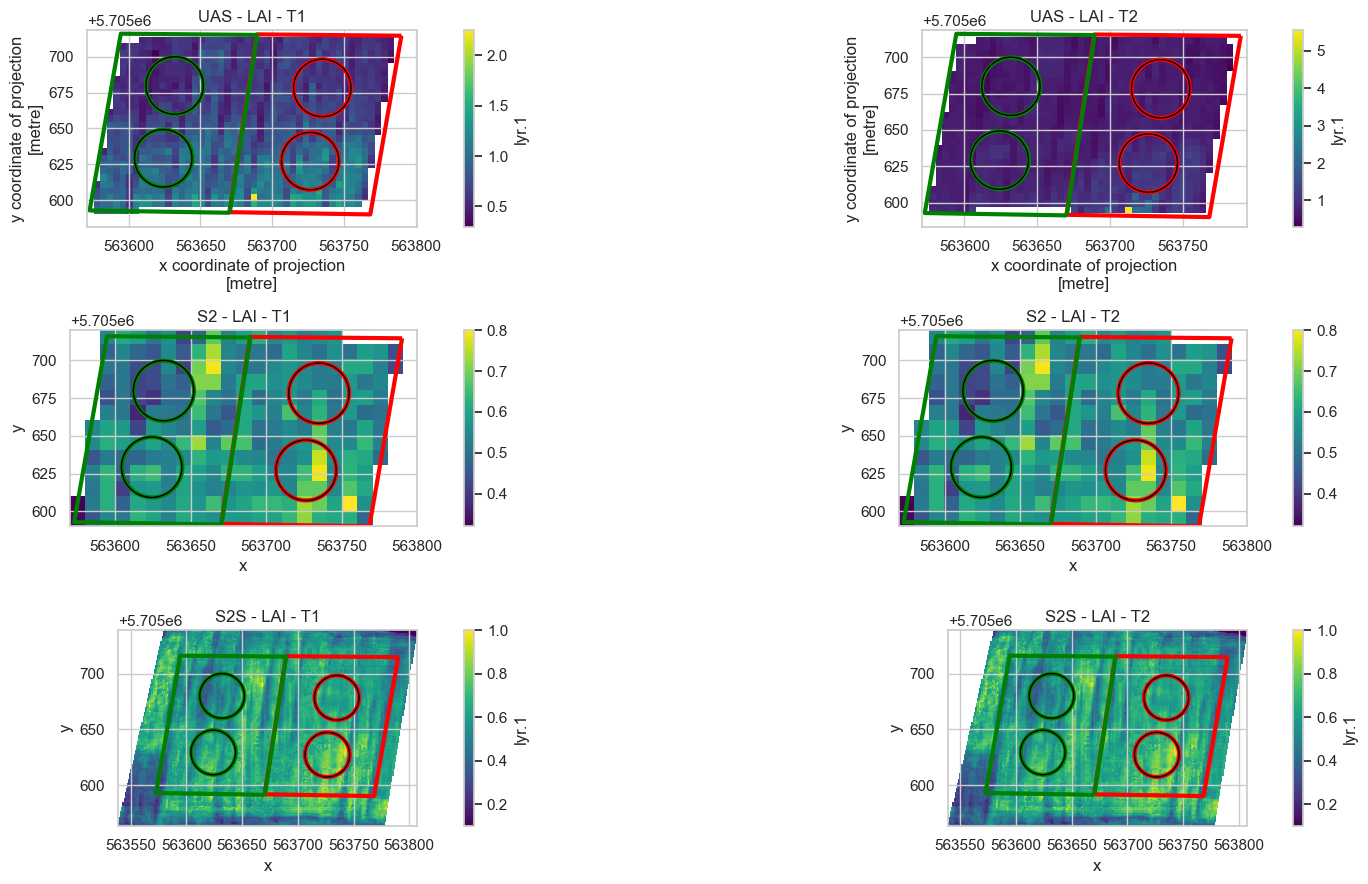

In [149]:
# Create a figure with a 2x3 subplot grid
fig = plt.figure(figsize=(18, 9))

# Create a gridspec with 2 columns and 3 rows
gs = gridspec.GridSpec(3, 2, width_ratios=[1, 1])

# Create subplots
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, 0])
ax4 = fig.add_subplot(gs[1, 1])
ax5 = fig.add_subplot(gs[2, 0])
ax6 = fig.add_subplot(gs[2, 1])


# UAS - LAI - T1
uas_1_rp.isel(band=0).plot.imshow(ax=ax1, cmap="viridis")
treated_roi.boundary.plot(ax=ax1, edgecolor='red', linewidth=3)
untreated_roi.boundary.plot(ax=ax1, edgecolor='green', linewidth=3)

treated_ino.boundary.plot(ax=ax1, edgecolor='black', linewidth=1)
untreated_ino.boundary.plot(ax=ax1, edgecolor='black', linewidth=1)

ax1.set_title("UAS - LAI - T1")

# UAS - LAI - T1
uas_2_rp.isel(band=0).plot.imshow(ax=ax2, cmap="viridis")
treated_roi.boundary.plot(ax=ax2, edgecolor='red', linewidth=3)
untreated_roi.boundary.plot(ax=ax2, edgecolor='green', linewidth=3)

treated_ino.boundary.plot(ax=ax2, edgecolor='black', linewidth=1)
untreated_ino.boundary.plot(ax=ax2, edgecolor='black', linewidth=1)

ax2.set_title("UAS - LAI - T2")

# S2 - LAI - T1
s2_1.isel(band=0).plot.imshow(ax=ax3, cmap="viridis")
treated_roi.boundary.plot(ax=ax3, edgecolor='red', linewidth=3)
untreated_roi.boundary.plot(ax=ax3, edgecolor='green', linewidth=3)

treated_ino.boundary.plot(ax=ax3, edgecolor='black', linewidth=1)
untreated_ino.boundary.plot(ax=ax3, edgecolor='black', linewidth=1)

ax3.set_title("S2 - LAI - T1")

# S2 - LAI - T2
s2_2.isel(band=0).plot.imshow(ax=ax4, cmap="viridis")
treated_roi.boundary.plot(ax=ax4, edgecolor='red', linewidth=3)
untreated_roi.boundary.plot(ax=ax4, edgecolor='green', linewidth=3)

treated_ino.boundary.plot(ax=ax4, edgecolor='black', linewidth=1)
untreated_ino.boundary.plot(ax=ax4, edgecolor='black', linewidth=1)

ax4.set_title("S2 - LAI - T2")

# S2S - LAI - T1
s2s_1.isel(band=0).plot.imshow(ax=ax5, cmap="viridis")
treated_roi.boundary.plot(ax=ax5, edgecolor='red', linewidth=3)
untreated_roi.boundary.plot(ax=ax5, edgecolor='green', linewidth=3)

treated_ino.boundary.plot(ax=ax5, edgecolor='black', linewidth=1)
untreated_ino.boundary.plot(ax=ax5, edgecolor='black', linewidth=1)

ax5.set_title("S2S - LAI - T1")

# S2S - LAI - T2
s2s_2.isel(band=0).plot.imshow(ax=ax6, cmap="viridis")
treated_roi.boundary.plot(ax=ax6, edgecolor='red', linewidth=3)
untreated_roi.boundary.plot(ax=ax6, edgecolor='green', linewidth=3)

treated_ino.boundary.plot(ax=ax6, edgecolor='black', linewidth=1)
untreated_ino.boundary.plot(ax=ax6, edgecolor='black', linewidth=1)

ax6.set_title("S2S - LAI - T2")
# Layout so plots do not overlap
fig.tight_layout()
plt.savefig(os.path.join(out, f"{current_date}_plot_vectorcheck_lai.png"), dpi=600, bbox_inches='tight')
plt.show()

### 5. Extract UAS-derived LAI values

In [150]:
def extract_raster_data(uas_1_rp, treated_roi, untreated_roi, treated_ino, untreated_ino, df_name="df_", value_column="values"):
    extractions = [
        (treated_roi,    "treated",   "non-inoculated"),
        (untreated_roi,  "untreated", "non-inoculated"),
        (treated_ino,    "treated",   "inoculated"),
        (untreated_ino,  "untreated", "inoculated")
    ]

    dfs = []

    for poly, treatment, region in extractions:
        clipped = uas_1_rp.rio.clip(poly.geometry, poly.crs, drop=True).isel(band=0)
        values = clipped.values.flatten()
        mask = ~np.isnan(values)
        values = values[mask]

        y_coords, x_coords = np.meshgrid(clipped['y'].values, clipped['x'].values, indexing='ij')
        x_flat = x_coords.flatten()[mask]
        y_flat = y_coords.flatten()[mask]

        df = pd.DataFrame({
            "x": x_flat,
            "y": y_flat,
            value_column: values,
            "treatment": treatment,
            "area": region,
            "source": df_name
        })

        dfs.append(df)

    df = pd.concat(dfs, ignore_index=True)
    return df

In [151]:
df_uas_1 = extract_raster_data(uas_1_rp, treated_roi, untreated_roi, treated_ino, untreated_ino, df_name="uas_t1", value_column="lai")
df_uas_1

,x,y,lai,treatment,area,source
0,563691.590973,5.705712e+06,0.65,treated,non-inoculated,uas_t1
1,563696.149238,5.705712e+06,0.60,treated,non-inoculated,uas_t1
2,563700.707504,5.705712e+06,0.50,treated,non-inoculated,uas_t1
3,563705.265769,5.705712e+06,0.45,treated,non-inoculated,uas_t1
4,563709.824035,5.705712e+06,0.75,treated,non-inoculated,uas_t1
...,...,...,...,...,...,...
1089,563636.891789,5.705616e+06,0.95,untreated,inoculated,uas_t1
1090,563618.658727,5.705611e+06,1.00,untreated,inoculated,uas_t1
1091,563623.216993,5.705611e+06,1.00,untreated,inoculated,uas_t1
1092,563627.775258,5.705611e+06,0.75,untreated,inoculated,uas_t1


In [152]:
df_uas_2 = extract_raster_data(uas_2_rp, treated_roi, untreated_roi, treated_ino, untreated_ino, df_name="uas_t2", value_column="lai")
df_uas_2

,x,y,lai,treatment,area,source
0,563689.382693,5.705711e+06,0.65,treated,non-inoculated,uas_t2
1,563694.033114,5.705711e+06,0.75,treated,non-inoculated,uas_t2
2,563698.683536,5.705711e+06,0.70,treated,non-inoculated,uas_t2
3,563703.333958,5.705711e+06,0.45,treated,non-inoculated,uas_t2
4,563707.984379,5.705711e+06,0.70,treated,non-inoculated,uas_t2
...,...,...,...,...,...,...
1040,563614.975946,5.705614e+06,0.90,untreated,inoculated,uas_t2
1041,563619.626368,5.705614e+06,0.75,untreated,inoculated,uas_t2
1042,563624.276790,5.705614e+06,0.85,untreated,inoculated,uas_t2
1043,563628.927211,5.705614e+06,0.55,untreated,inoculated,uas_t2


### 6. Extract S2-derived LAI values

In [153]:
df_s2_1 = extract_raster_data(s2_1, treated_roi, untreated_roi, treated_ino, untreated_ino, df_name="s2_t1", value_column="lai")
df_s2_1

,x,y,lai,treatment,area,source
0,563695.0,5705715.0,0.62,treated,non-inoculated,s2_t1
1,563705.0,5705715.0,0.55,treated,non-inoculated,s2_t1
2,563715.0,5705715.0,0.58,treated,non-inoculated,s2_t1
3,563725.0,5705715.0,0.53,treated,non-inoculated,s2_t1
4,563735.0,5705715.0,0.55,treated,non-inoculated,s2_t1
...,...,...,...,...,...,...
247,563625.0,5705625.0,0.65,untreated,inoculated,s2_t1
248,563635.0,5705625.0,0.53,untreated,inoculated,s2_t1
249,563615.0,5705615.0,0.57,untreated,inoculated,s2_t1
250,563625.0,5705615.0,0.58,untreated,inoculated,s2_t1


In [154]:
df_s2_2 = extract_raster_data(s2_2, treated_roi, untreated_roi, treated_ino, untreated_ino, df_name="s2_t2", value_column="lai")
df_s2_2

,x,y,lai,treatment,area,source
0,563695.0,5705715.0,0.62,treated,non-inoculated,s2_t2
1,563705.0,5705715.0,0.55,treated,non-inoculated,s2_t2
2,563715.0,5705715.0,0.58,treated,non-inoculated,s2_t2
3,563725.0,5705715.0,0.53,treated,non-inoculated,s2_t2
4,563735.0,5705715.0,0.55,treated,non-inoculated,s2_t2
...,...,...,...,...,...,...
247,563625.0,5705625.0,0.65,untreated,inoculated,s2_t2
248,563635.0,5705625.0,0.53,untreated,inoculated,s2_t2
249,563615.0,5705615.0,0.57,untreated,inoculated,s2_t2
250,563625.0,5705615.0,0.58,untreated,inoculated,s2_t2


### 7. Extract S2S-derived LAI values

In [155]:
df_s2s_1 = extract_raster_data(s2s_1, treated_roi, untreated_roi, treated_ino, untreated_ino, df_name="s2s_t1", value_column="lai")
df_s2s_1

,x,y,lai,treatment,area,source
0,563689.5,5705715.5,0.50,treated,non-inoculated,s2s_t1
1,563690.5,5705715.5,0.51,treated,non-inoculated,s2s_t1
2,563691.5,5705715.5,0.52,treated,non-inoculated,s2s_t1
3,563692.5,5705715.5,0.54,treated,non-inoculated,s2s_t1
4,563693.5,5705715.5,0.59,treated,non-inoculated,s2s_t1
...,...,...,...,...,...,...
24317,563623.5,5705609.5,0.86,untreated,inoculated,s2s_t1
24318,563624.5,5705609.5,0.81,untreated,inoculated,s2s_t1
24319,563625.5,5705609.5,0.71,untreated,inoculated,s2s_t1
24320,563626.5,5705609.5,0.72,untreated,inoculated,s2s_t1


In [156]:
df_s2s_2 = extract_raster_data(s2s_2, treated_roi, untreated_roi, treated_ino, untreated_ino, df_name="s2s_t2", value_column="lai")
df_s2s_2

,x,y,lai,treatment,area,source
0,563689.5,5705715.5,0.50,treated,non-inoculated,s2s_t2
1,563690.5,5705715.5,0.51,treated,non-inoculated,s2s_t2
2,563691.5,5705715.5,0.52,treated,non-inoculated,s2s_t2
3,563692.5,5705715.5,0.54,treated,non-inoculated,s2s_t2
4,563693.5,5705715.5,0.59,treated,non-inoculated,s2s_t2
...,...,...,...,...,...,...
24317,563623.5,5705609.5,0.86,untreated,inoculated,s2s_t2
24318,563624.5,5705609.5,0.81,untreated,inoculated,s2s_t2
24319,563625.5,5705609.5,0.71,untreated,inoculated,s2s_t2
24320,563626.5,5705609.5,0.72,untreated,inoculated,s2s_t2


### 8. Concatenate and clean dataframes

In [157]:
# Concatenate the individual DataFrames (df_s2_prediction, df_uav_prediction, etc.)
df_all = pd.concat([df_uas_1, df_uas_2, df_s2_1, df_s2_2, df_s2s_1, df_s2s_2], ignore_index=True)

df_all.to_csv(os.path.join(out, f"{current_date}_fulldf_lai_cercospoRa.csv"), index=False)

df_untreated = df_all[df_all["treatment"] == "untreated"]

# Drop any rows where 'source' is missing (optional)
df_untreated = df_untreated .dropna(subset=['source'])

# Split the source column at the underscore
df_untreated [['platform', 'time']] = df_untreated ['source'].str.split('_', expand=True)

# Show the resulting DataFrame
df_untreated

,x,y,lai,treatment,area,source,platform,time
427,563609.542196,5.705712e+06,0.50,untreated,non-inoculated,uas_t1,uas,t1
428,563614.100462,5.705712e+06,0.55,untreated,non-inoculated,uas_t1,uas,t1
429,563618.658727,5.705712e+06,0.45,untreated,non-inoculated,uas_t1,uas,t1
430,563623.216993,5.705712e+06,0.45,untreated,non-inoculated,uas_t1,uas,t1
431,563627.775258,5.705712e+06,0.55,untreated,non-inoculated,uas_t1,uas,t1
...,...,...,...,...,...,...,...,...
51282,563623.500000,5.705610e+06,0.86,untreated,inoculated,s2s_t2,s2s,t2
51283,563624.500000,5.705610e+06,0.81,untreated,inoculated,s2s_t2,s2s,t2
51284,563625.500000,5.705610e+06,0.71,untreated,inoculated,s2s_t2,s2s,t2
51285,563626.500000,5.705610e+06,0.72,untreated,inoculated,s2s_t2,s2s,t2


### 9. Summarize LAI (untreated) data

In [158]:
# Group and summarize
summary = df_untreated.groupby(['area', 'source'])['lai'].describe().round(2)

# Optional: reset index for flat table display
summary = summary.reset_index()

# Save the summary to a CSV file
summary.to_csv(os.path.join(out, f"{current_date}_summary_desc_stats_lai_cercospoRa.csv"), index=False)

# Display the summary (optional)
summary

,area,source,count,mean,std,min,25%,50%,75%,max
0,inoculated,s2_t1,28.0,0.51,0.06,0.39,0.47,0.50,0.54,0.65
1,inoculated,s2_t2,28.0,0.51,0.06,0.39,0.47,0.50,0.54,0.65
2,inoculated,s2s_t1,2523.0,0.58,0.11,0.32,0.50,0.57,0.65,0.86
3,inoculated,s2s_t2,2523.0,0.58,0.11,0.32,0.50,0.57,0.65,0.86
4,inoculated,uas_t1,126.0,0.71,0.21,0.35,0.55,0.70,0.85,1.15
5,inoculated,uas_t2,116.0,0.72,0.14,0.35,0.60,0.75,0.85,1.05
6,non-inoculated,s2_t1,99.0,0.55,0.08,0.32,0.51,0.54,0.60,0.79
7,non-inoculated,s2_t2,99.0,0.55,0.08,0.32,0.51,0.54,0.60,0.79
8,non-inoculated,s2s_t1,9416.0,0.61,0.11,0.24,0.54,0.62,0.69,0.99
9,non-inoculated,s2s_t2,9416.0,0.61,0.11,0.24,0.54,0.62,0.69,0.99


### 10. Verify position of extracted coordinates

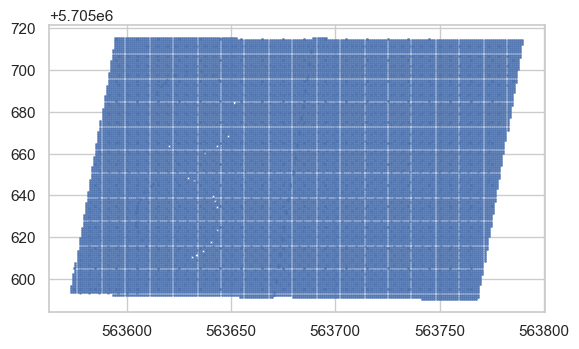

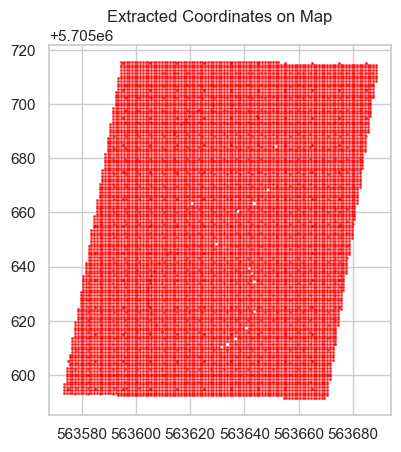

In [159]:
# Create geometry column from x and y
geometry = [Point(xy) for xy in zip(df_all["x"], df_all["y"])]
geometry_un = [Point(xy) for xy in zip(df_untreated["x"], df_untreated["y"])]
gdf = gpd.GeoDataFrame(df_all, geometry=geometry, crs="EPSG:32633")  # Replace with your CRS
gdf_un = gpd.GeoDataFrame(df_untreated, geometry=geometry_un, crs="EPSG:32633")  # Replace with your CRS
# Plot
gdf.plot(markersize=1, alpha=0.5)
gdf_un.plot(markersize=1, alpha=0.5, color="red")
plt.title("Extracted Coordinates on Map")
plt.show()

### 11. Visualize untreated LAI data

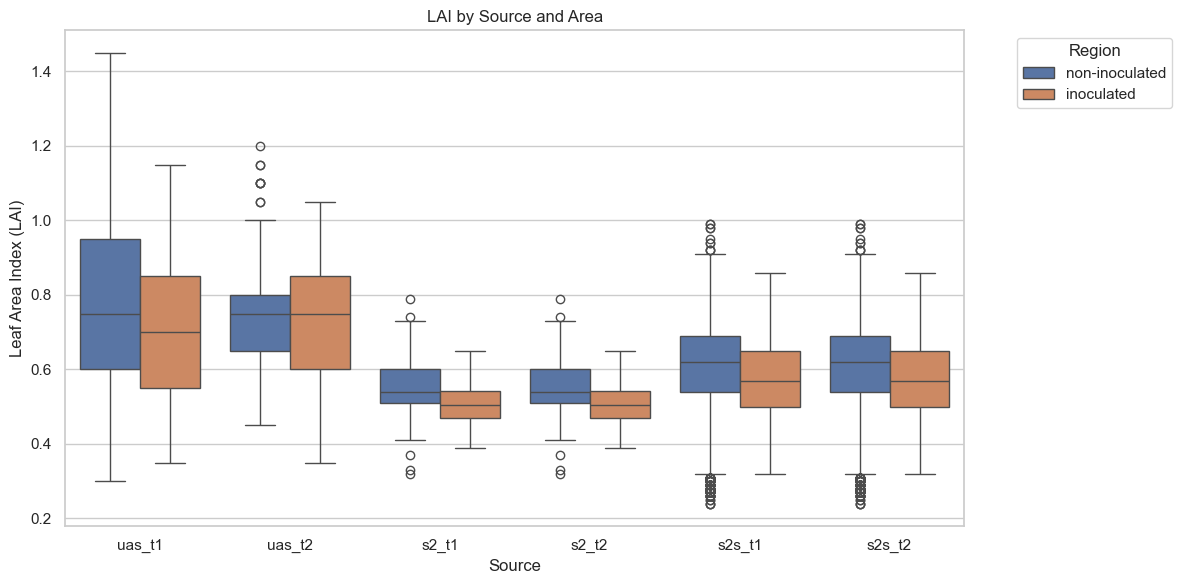

In [160]:
# Set plot style
sns.set(style="whitegrid")

# Create a boxplot of LAI by source and region
plt.figure(figsize=(12, 6))
sns.boxplot(x="source", y="lai", hue="area", data=df_untreated)

# Add titles and labels
plt.title("LAI by Source and Area")
plt.xlabel("Source")
plt.ylabel("Leaf Area Index (LAI)")
plt.legend(title="Region", bbox_to_anchor=(1.05, 1), loc='upper left')

# Show plot
plt.tight_layout()
plt.show()

In [161]:
print("Success.")

Success.
